# 00.2 - Analysis - K<sub>d</sub>

## Background
The dump assays were tricky to correct for - in terms of each compounds' absorbance.
Multiple concenctrations provides extra information that can help correct for data corruption in reads.
It also allows for calculcation of K<sub>d</sub>.

- [Design](00.2-design.ipynb)
- [Lab Notes](00.2-labNotes.ipynb)

## Aim

## Summary
Some of the data is bad and beyond saving.
There's plenty of good data, but no binders, so I can't test downstream.

I haven't been controlling for DMSO vol like I used to, and maybe that's ok - it was a significant cost in time and plates etc.
Eyeballing it, it looks fine.

## Next

----

## Data Munging

In [1]:
import os
from string import ascii_lowercase, ascii_uppercase
from ast import literal_eval
import numpy as np
from scipy.ndimage import gaussian_filter1d, convolve1d
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns


dataDir = 'platereader'
paths = sorted([os.path.join(dataDir, i) for i in os.listdir(dataDir)])
print(paths)

def parse(path):
    df = pd.read_csv(path, skiprows=6)
    wells = [f'{i}{j}' for i,j in zip(df['Unnamed: 0'], df['Unnamed: 1'])]
    df.index =  wells
    for i in ['Unnamed: 0','Unnamed: 1','Wavelength [nm]']:
        if i in df.columns:
            df.drop(i,axis=1, inplace=True)
    df.dropna(axis=1, inplace=True)
    df=df.replace('overflow', 3.5)
    df.columns = list(map(int, df.columns)) # wavelengths
    return df

ctrl = parse(paths[0])
test = parse(paths[1])

picklist_ctrl = pd.read_csv('echo/picklists/2022-03-07-00.2-picklist-ctrl.csv')
picklist_test = pd.read_csv('echo/picklists/2022-03-07-00.2-picklist-test.csv')

cpds = [literal_eval(i)[0] for i in picklist_test.Cpd]
picklist_ctrl.Cpd = cpds
picklist_test.Cpd = cpds

ctrl_wells = {i:picklist_ctrl.loc[picklist_ctrl.Cpd == i, :] for i in picklist_ctrl.Cpd.unique()}
test_wells = {i:picklist_test.loc[picklist_test.Cpd == i, :] for i in picklist_test.Cpd.unique()}

['platereader/2022-03-07-00.2-ctrl.CSV', 'platereader/2022-03-07-00.2-test.CSV', 'platereader/2022-03-09-00.2-hamilton-ctrl.CSV', 'platereader/2022-03-09-00.2-hamilton-test.CSV']


## Plate Layout

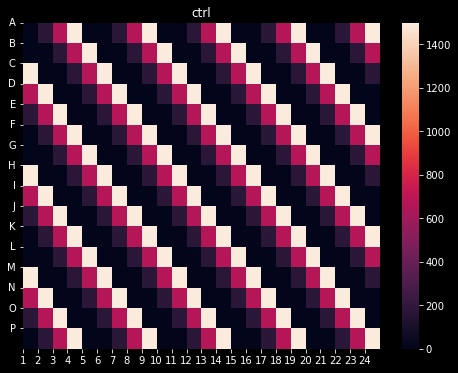

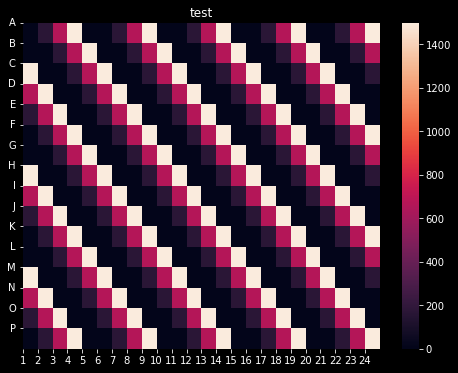

In [2]:
class WellArr:
    def __init__(self):
        self.x = np.zeros((16,24))
    def __getitem__(self, idx):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            return self.x[i,j]
    def __setitem__(self, idx, new):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            self.x[i,j] = new
    def __len__(self):
        return len(self.x.flatten())
    
x_ctrl = WellArr()
for i, j in zip(picklist_ctrl.DestWell, 
                picklist_ctrl['Transfer Volume /nl']):
    x_ctrl[i] = j
plt.figure(figsize=(8,6))
sns.heatmap(x_ctrl.x, annot=False)
plt.xticks(range(24), range(1,25))
plt.yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
plt.title('ctrl')
plt.show()

x_test = WellArr()
for i, j in zip(picklist_test.DestWell, 
                picklist_test['Transfer Volume /nl']):
    x_test[i] = j
plt.figure(figsize=(8,6))
sns.heatmap(x_test.x, annot=False)
plt.xticks(range(24), range(1,25))
plt.yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
plt.title('test')
plt.show()

## Hand Dispensed Protein

##  Protein Only

Here's what the protein - no compound wells looked like across the plate

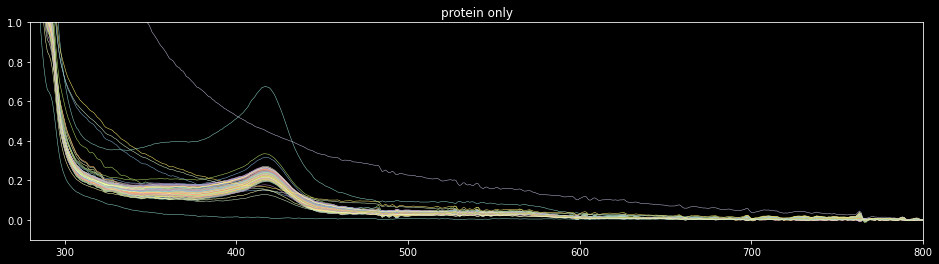

In [3]:
blank_idx = [i for i in test.index if i not in picklist_test.DestWell.to_list()]
test_blanks = test.loc[blank_idx,:]
test_blanksz800 = test_blanks.sub(test_blanks.loc[:,800], axis=0)

plt.figure(figsize=(16,4))
for i in test_blanksz800.index:
    plt.plot(test_blanksz800.loc[i,:], lw=0.5)
plt.title('protein only')
plt.xlim(280,800)
plt.ylim(-0.1,1)
plt.show()

## Diffs

The gradient of the trace at each wavelength.

Maybe this is an ok way to normalize the signals to eachother.
Maybe.
Here's what the diffs of the protein traces above look like:

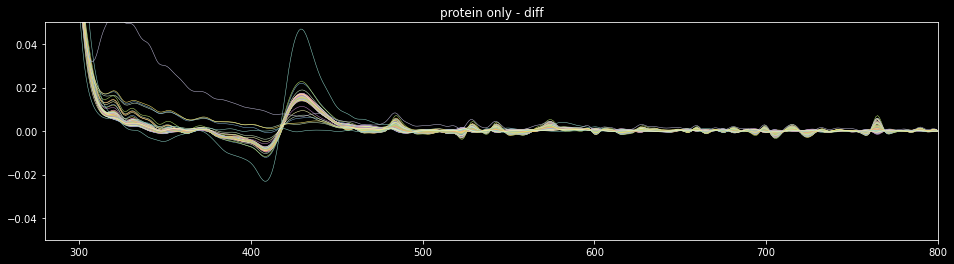

In [4]:
test_blanksz800Diff = pd.DataFrame(convolve1d(gaussian_filter1d(test_blanksz800, 3), 
                                              np.array([-1,0,1])), 
                                   index=test_blanksz800.index,
                                   columns=test_blanksz800.columns)

plt.figure(figsize=(16,4))
for i in test_blanksz800Diff.index:
    plt.plot(test_blanksz800Diff.loc[i,:], lw=0.5)
plt.title('protein only - diff')
plt.xlim(280,800)
plt.ylim(-0.05,0.05)
plt.show()

## Util fns
Subtracted ctrl diffs from test - looks shite.

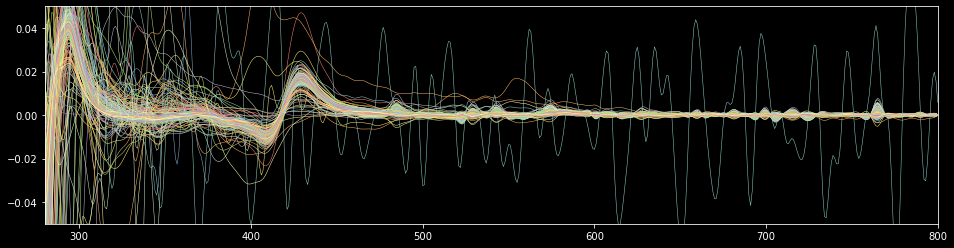

In [5]:
def proc(df):
    cols = df.columns
    idx = df.index
    dfZ800 = df.sub(df.loc[:,800], axis=0)
    dfSmth = pd.DataFrame(gaussian_filter1d(dfZ800, 3),
                          index=idx,
                          columns=cols)
    return dfSmth


def procDiff(df):
    cols = df.columns
    idx = df.index
    dfZ800 = df.sub(df.loc[:,800], axis=0)
    dfDiff = pd.DataFrame(convolve1d(gaussian_filter1d(dfZ800, 3), 
                                     np.array([-1,0,1])), 
                           index=idx,
                           columns=cols)
    return dfDiff

dd = procDiff(test) - procDiff(ctrl)

plt.figure(figsize=(16,4))
for i in dd.index:
    plt.plot(dd.loc[i,:], lw=0.5)
plt.xlim(280,800)
plt.ylim(-0.05,0.05)
plt.show()

## Here's everything plotted
Except the 0 concentration.


  0%|          | 0/26 [00:00<?, ?it/s]

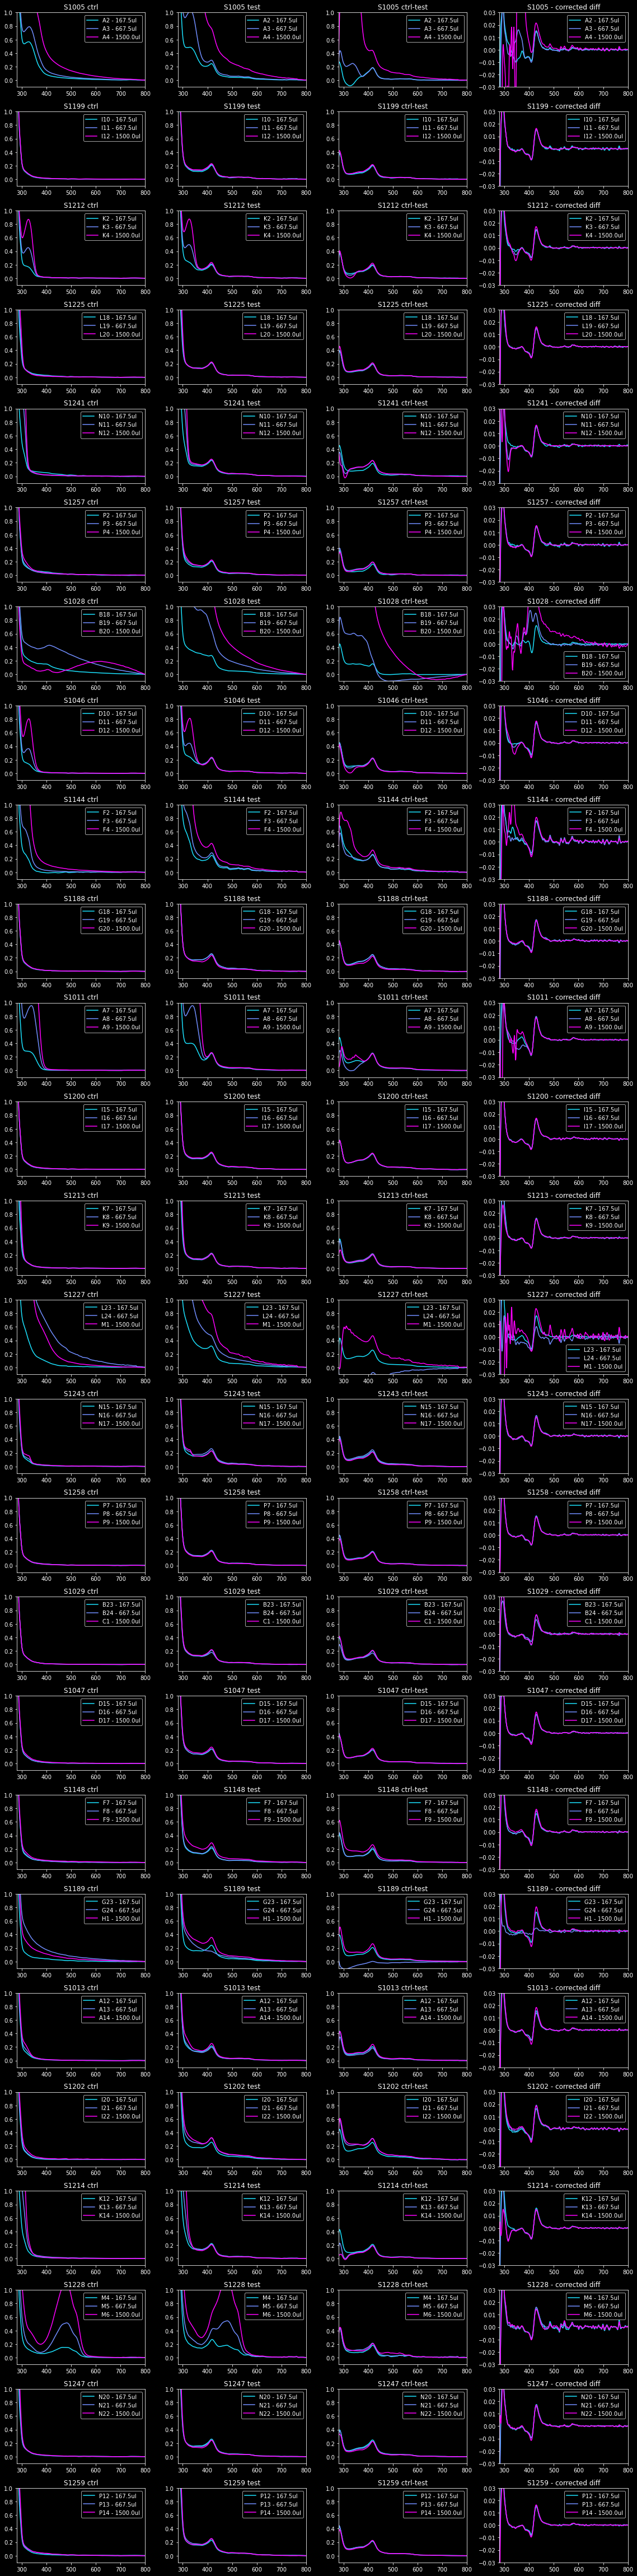

In [6]:
from tqdm.notebook import tqdm

fig, ax = plt.subplots(26, 4, figsize=(16,64))
for i,j,k in tqdm(zip(ax, test_wells, ctrl_wells), total=len(ax)):
    test_wells_ = test_wells[j]['DestWell']
    ctrl_wells_ = ctrl_wells[j]['DestWell']
    t_  = proc(test.loc[test_wells_,:])
    c_  = proc(ctrl.loc[ctrl_wells_,:])
    dt_ = procDiff(test.loc[test_wells_,:])
    dc_ = procDiff(ctrl.loc[ctrl_wells_,:])
    x = t_ - c_
    dx = dt_ - dc_
    for l,m in zip(c_.index,ctrl_wells[k]['Transfer Volume /nl']):
        i[0].plot(c_.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[0].legend()
    for l,m in zip(t_.index,test_wells[j]['Transfer Volume /nl']):
        i[1].plot(t_.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[1].legend()
    for l,m in zip(x.index,test_wells[j]['Transfer Volume /nl']):
        i[2].plot(x.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[2].legend()
    for l,m in zip(dx.index,test_wells[j]['Transfer Volume /nl']):
        i[3].plot(dx.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[3].legend()
    for ax_, label in zip(i[:-1], ['ctrl','test','ctrl-test','diff']):
        ax_.set_xlim(280,800)
        ax_.set_ylim(-0.1,1)
        ax_.set_title(f'{j} {label}')
    i[-1].set_xlim(280,800)
    i[-1].set_ylim(-0.03, 0.03)
    i[-1].set_title(f'{j} - corrected diff')
        
plt.tight_layout()
plt.show()

## Hamilton Dispensing

In [7]:
paths

['platereader/2022-03-07-00.2-ctrl.CSV',
 'platereader/2022-03-07-00.2-test.CSV',
 'platereader/2022-03-09-00.2-hamilton-ctrl.CSV',
 'platereader/2022-03-09-00.2-hamilton-test.CSV']

  0%|          | 0/24 [00:00<?, ?it/s]

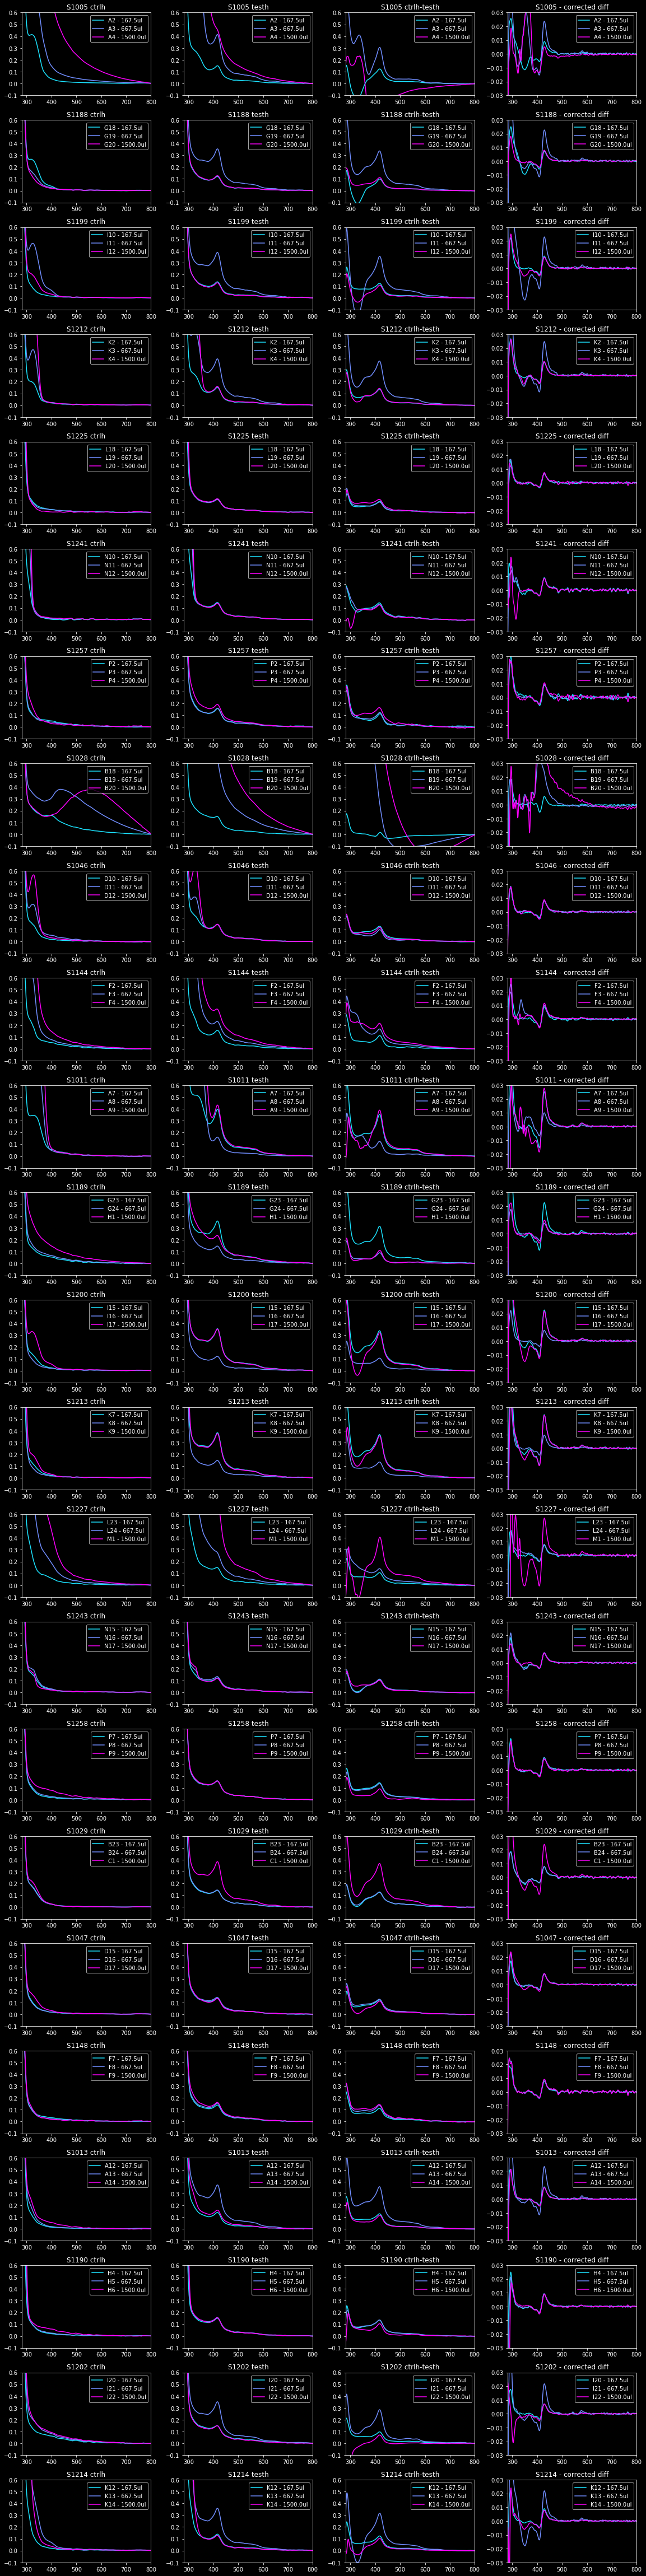

In [11]:

ctrlh = parse(paths[2])
testh = parse(paths[3])

picklist_ctrlh = pd.read_csv('echo/picklists/2022-03-08-00.2-picklist-ctrl.csv')
picklist_testh = pd.read_csv('echo/picklists/2022-03-08-00.2-picklist-test.csv')

cpds = [literal_eval(i)[0] for i in picklist_testh.Cpd]
picklist_ctrlh.Cpd = cpds
picklist_testh.Cpd = cpds

ctrlh_wells = {i:picklist_ctrlh.loc[picklist_ctrlh.Cpd == i, :] for i in picklist_ctrlh.Cpd.unique()}
testh_wells = {i:picklist_testh.loc[picklist_testh.Cpd == i, :] for i in picklist_testh.Cpd.unique()}

fig, ax = plt.subplots(24, 4, figsize=(16,64))
for i,j,k in tqdm(zip(ax, testh_wells, ctrlh_wells),total=len(ax)):
    testh_wells_ = testh_wells[j]['DestWell']
    ctrlh_wells_ = ctrlh_wells[k]['DestWell']
    # issue in proc
    t_  = proc(testh.loc[testh_wells_,:]).drop_duplicates()
    c_  = proc(ctrlh.loc[ctrlh_wells_,:]).drop_duplicates()
    dt_ = procDiff(testh.loc[testh_wells_,:]).drop_duplicates()
    dc_ = procDiff(ctrlh.loc[ctrlh_wells_,:]).drop_duplicates()
    x = t_ - c_
    dx = dt_ - dc_
    for l,m in zip(c_.index,ctrlh_wells[k]['Transfer Volume /nl']):
        i[0].plot(c_.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[0].legend()
    for l,m in zip(t_.index,testh_wells[j]['Transfer Volume /nl']):
        i[1].plot(t_.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[1].legend()
    for l,m in zip(x.index,testh_wells[j]['Transfer Volume /nl']):
        i[2].plot(x.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[2].legend()
    for l,m in zip(dx.index,testh_wells[j]['Transfer Volume /nl']):
        i[3].plot(dx.loc[l,:], label=f'{l} - {m}ul', c=plt.cm.cool(m/1500))
        i[3].legend()
    for ax_, label in zip(i[:-1], ['ctrlh','testh','ctrlh-testh','diff']):
        ax_.set_xlim(280,800)
        ax_.set_ylim(-0.1,0.6)
        ax_.set_title(f'{j} {label}')
    i[-1].set_xlim(280,800)
    i[-1].set_ylim(-0.03, 0.03)
    i[-1].set_title(f'{j} - corrected diff')
        
plt.tight_layout()
plt.show()

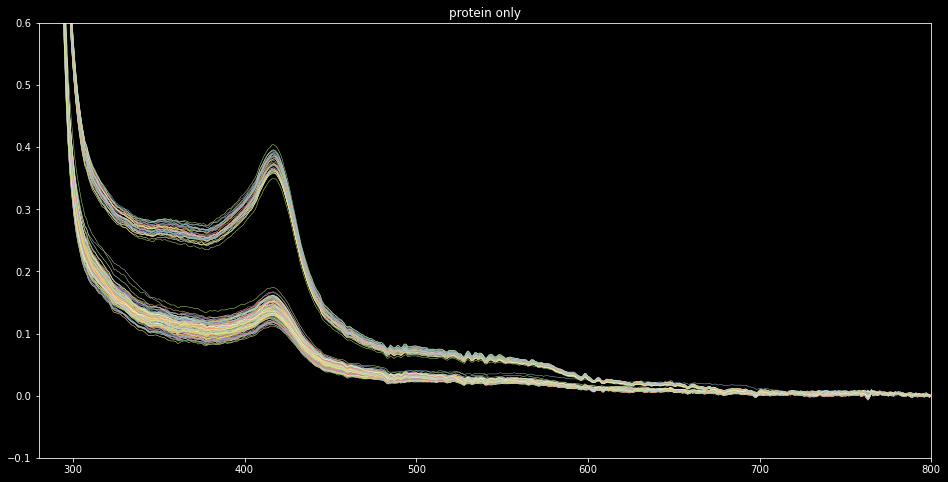

In [13]:
blank_idx = [i for i in testh.index if i not in picklist_testh.DestWell.to_list()]
testh_blanks = testh.loc[blank_idx,:]
testh_blanksz800 = testh_blanks.sub(testh_blanks.loc[:,800], axis=0)

plt.figure(figsize=(16,8))
for i in testh_blanksz800.index:
    plt.plot(testh_blanksz800.loc[i,:], lw=0.5)
plt.title('protein only')
plt.xlim(280,800)
plt.ylim(-0.1,0.6)
plt.show()

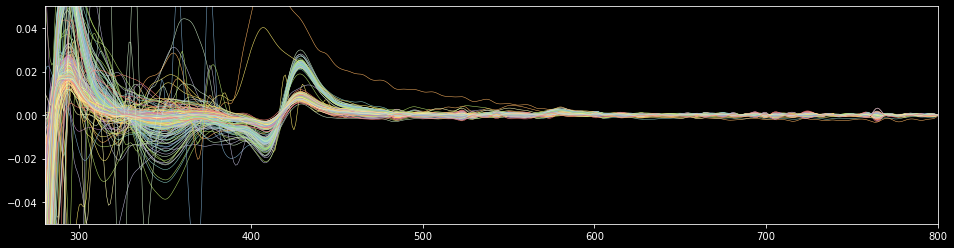

In [10]:
dd = procDiff(testh) - procDiff(ctrlh)

plt.figure(figsize=(16,4))
for i in dd.index:
    plt.plot(dd.loc[i,:], lw=0.5)
plt.xlim(280,800)
plt.ylim(-0.05,0.05)
plt.show()